In [ ]:
import numpy as np

In [ ]:
W = np.random.randn(7,3)
b = np.random.randn(3)

params = [W]
print(params)

W,= params # コンマがあるとparamsリスト内の要素を取り出して格納（カンマなしだとリストそのまま格納）
print(W)

idx = [1, 0, 3, 0]
print(W[idx])

Embeddingレイヤ（分散表現を取り出すレイヤ）

In [ ]:
# 全分散表現を格納するWから単語ID(idx)で必要な分散表現だけ抜き出す（埋め込み）
# hot-one入力との積計算を省略できる
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    # 全分散表現Wのうちidx番目(=word_id)の分散表現を抜き出す
    def forward(self, idx):
        W, = self.params
        self.idx = idx # ミニバッチデータならリスト
        out = W[idx] # リストを入れるとまとめてバッチサイズ分の分散表現をまとめて取得

        return out

    def backward(self, dout):
        dW, = self.grads
        # MatMaulやAffineでは全てのWを参照し、全てのdWを更新したが、
        # Embeddingでは必要なWの要素だけを抜き出している
        # つまり計算毎に抜き出したWだけに対応するdWを計算するから前の計算結果は無関係
        dW[...] = 0 # 前の計算結果残さないためdWの要素を0に上書き

        # それぞれおの勾配を対応する単語IDのdWに渡す
        for i, word_id in enumerate(self.idx):
            # dW[word_id] += dout[i] # 時間かかる
            np.add.at(dW, self.idx, dout) # dWをidxの行（対応する単語ID)のdWに加算

        return None


In [ ]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W) # 全分散表現を渡す
        self.params = self.embed.params # 全分散表現
        self.grads = self.embed.grads # それに対応する全勾配
        self.cache = None # １試行毎の抜き出された分散表現を格納するための変数

    def forward(self, h, idx): # h: コンテキストの平均化された分散表現（行ベクトル）
        target_W = self.embed.forward(idx) #idx(単語ID)のターゲット分散表現を抜き出す（行ベクトル）
        # 転置とnp.dotを使うと対応する行ベクトル同士以外の内積まで計算される（下のセル参考）
        out = np.sum(target_W * h, axis=1) # 対応する行ベクトル同士の内積だけ求めたい
        # e.g. コンテキストh_aに対してターゲットw_aがありコンテキストh_bとターゲットw_aは関係ないから内積を求める理由がない

        self.cache = (h, target_W) # 今回の試行で扱った抜き出されたコンテキストとターゲットの分散表現を保持（逆伝播で再利用）
        return out

    def backward(self, dout):
        h, target_W = self.cache # 今回の試行で扱った抜き出されたコンテキストとターゲットの分散表現を呼び出す

        # 後ろの層の出力(勾配の数)分の列ベクトルに再構成（ターゲット数（バッチサイズ）と同じ）
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W) # それぞれの勾配がidx(ID)の分散表現に対する勾配に加算される
        dh = dout * target_W
        return dh #入力（コンテキスト）の分散表現に対する勾配計算（逆伝播）に使用する

In [ ]:
dout = np.array([2, 3])  # (2,)
h = np.array([[1, 2, 3],
              [4, 5, 6]
              ])
print(h.shape)
w = np.array([[10, 20, 30],
              [40, 50, 60],
             ])
print(w.shape)

print(np.sum(w * h, axis=1))
out = np.dot(w,h.T) #余計な内積が２つ求まる
print(out)


UnigramSampler(一単語をターゲットに確率分布を作成、語彙からランダムに選択)

In [ ]:
# ランダムサンプリング
random_number = np.random.choice(10)
print(random_number)

words = ['you', 'say', 'goodby', 'I', 'hello', '.']

random_word = np.random.choice(words)
print(random_word)

overlap_random_words = np.random.choice(words, size=5)
print(overlap_random_words)

unoverlap_random_words = np.random.choice(words, size=5, replace=False)
print(unoverlap_random_words)

p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
set_chance_words = np.random.choice(words, p=p)
print(set_chance_words)

In [ ]:
# 確率分布の0.75乗（確率の低い単語の確率を少しだけ上げる）
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
print(new_p)

In [ ]:
import collections
# 各データ（ターゲット）に対して負例の単語を確率分布に沿ってサンプリング
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size # 各データに対する負例の数
        self.vocab_size = None
        self.word_p = None # コーパス内単語頻出率に基づいた確率分布

        counts = collections.Counter()
        # コーパス内の単語IDの出現回数をカウント
        for word_id in corpus:
            counts[word_id] += 1 # キー：単語ID 値：出現回数

        # 語彙数
        vocab_size = len(counts)
        self.vocab_size = vocab_size

        # 語彙数と同一のゼロベクトルリスト生成
        self.word_p = np.zeros(vocab_size)
        # 単語ID順に出現回数を格納（確率分布設定に辞書ではキーが邪魔だからリストに入れ直す）
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        # 0.75乗して確率分布作成
        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0] # (ターゲット数×分散表現)

        if not GPU:
            # 各ターゲットに対し設定した負例サンプル数が並ぶ配列の初期化
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)
            # バッチ内の各ターゲット
            for i in range(batch_size):
                # 初期確率分布のコピー（ターゲットを除いた新しい確率分布を作成するから）
                p = self.word_p.copy()
                target_idx = target[i] # バッチ内i番目のターゲットの単語ID取得
                p[target_idx] = 0 # コピーした確率分布におけるターゲットの確率を０にする
                p /= p.sum() # そのうえで改めて全体の確率分布を計算
                # バッチ内i番目のターゲット対して、確率分布に従い単語IDをランダムに取得
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）で計算するときは、速度を優先
            # 負例にターゲットが含まれるケースがある（確率分布からターゲットを排除していない）
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample

In [ ]:
# corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
# power = 0.75
# sample_size = 2

# sampler = UnigramSampler(corpus, power, sample_size)
# target = np.array([1, 3, 0])
# negative_sample = sampler.get_negative_sample(target)
# print(negative_sample)

NgativeSamplingLoss(負例も含めたEmbeddingDotからのスコアをもらってsigmoidで二値分類、損失計算まで)

In [ ]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
from common.layers import SigmoidWithLoss
from ch04 import UnigramSampler

class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        # 初期確率分布生成
        self.sampler = UnigramSampler(corpus, power, sample_size)
        # 正例（１つ）+ 負例（sample_size）分のレイヤリストを生成
        ## それぞれW_outから必要な分散表現(正例か負例)を抜き出しhとの内積を求める
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        ## それぞれの内積から損失を計算（最後に集計）
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]

        # 各EmbeddingDotレイヤにあるパラメータと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    # 正例と負例それぞれでスコア（内積）を取得しsigmoid通して損失計算
    def forward(self, h, target):
        batch_size = target.shape[0]

        # 正例のフォワード（スコアが高いほど良い）：第０番目レイヤ
        # コンテキストと正解（target）の分散表現における内積（スコア）：当然高いはず
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32 ) # 正例だから正解ラベルを１
        # SigmoidWithLossにスコアと対する正解ラベル(t)１を渡す：この時スコアが高ければ損失は小さくなる
        loss = self.loss_layers[0].forward(score, correct_label)

        # 負例のフォワード（スコアが低いほど良い）：残りのレイヤ
        # targetを除いた確率分布に基づいて負例の単語IDをサンプリング
        negative_sample = self.sampler.get_negative_sample(target)
        negative_label = np.zeros(batch_size, dtype=np.int32) # 負例だから正解ラベルを０
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i] # i番目の負例の分散表現
            # コンテキストと不正解（tnegative_arget）の分散表現における内積（スコア）：当然低いはず
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            # 正例と全負例における損失の合計
            ## SigmoidWithLossにスコアと対する正解ラベル(t)0を渡す：この時スコアが低ければ損失は小さくなる
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    # 全電波のときと逆順に各レイヤのbackward()を呼ぶ
    def backward(self, dout=1):
        dh = 0 # 前伝播でhを複数レイヤにコピーされRepeatノードに相当するため、逆伝播では全勾配の合計がdhになる
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

モデルCBOW実装

In [ ]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')

from ch04.negative_sampling_layer import NegativeSamplingLoss
from common.layers import Embedding
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 重みの初期化(W_in, W_out共に行ベクトル抜き出して内積求める)
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f') # (H, V)じゃなくていい

        # レイヤの生成
        self.in_layers = [] # 入力(コンテキスト)用のレイヤリスト
        for i in range(2 * window_size): # 2 * window_sizeの分コンテキストがある
            layer = Embedding(W_in)  # Embeddingレイヤを使用
            self.in_layers.append(layer)
        # out_layer(EmbeddingDot)からsigmoid、損失関数まで全込
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # すべての重みと勾配をリストにまとめる
        layers = self.in_layers + [self.ns_loss] # 前レイヤを一つのリストにまとめる
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 入力の重み(コンテキストの分散表現)を最終的に推論で使うパラメータとして設定
        self.word_vecs = W_in

    # 推論
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers): # 入力レイヤ（ターゲットの前か後のコンテキスト）
            h += layer.forward(contexts[:, i]) # 前後のコンテキストの分散表現を加算
        h *= 1 / len(self.in_layers) # 　コンテキスト分散表現の平均
        loss = self.ns_loss.forward(h, target) # 正例と全負例の損失の合計
        return loss

    # 学習（パラメータ更新）
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout) #損失、sigmoid, EmbeddingDotまでの逆伝播
        dout *= 1 / len(self.in_layers) # 前伝播でした平均の逆伝播
        for layer in self.in_layers: # 残り入力レイヤの逆伝播
            layer.backward(dout)
        return None

------------------------------------------------------------
                       GPU Mode (cupy)
------------------------------------------------------------

| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 0[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 0[s] | loss 4.13
| epoch 1 |  iter 81 / 9295 | time 1[s] | loss 4.05
| epoch 1 |  iter 101 / 9295 | time 1[s] | loss 3.93
| epoch 1 |  iter 121 / 9295 | time 1[s] | loss 3.79
| epoch 1 |  iter 141 / 9295 | time 1[s] | loss 3.64
| epoch 1 |  iter 161 / 9295 | time 1[s] | loss 3.49
| epoch 1 |  iter 181 / 9295 | time 2[s] | loss 3.38
| epoch 1 |  iter 201 / 9295 | time 2[s] | loss 3.28
| epoch 1 |  iter 221 / 9295 | time 2[s] | loss 3.16
| epoch 1 |  iter 241 / 9295 | time 2[s] | loss 3.10
| epoch 1 |  iter 261 / 9295 | time 2[s] | loss 3.03
| epoch 1 |  iter 281 / 9295 | time 3[s] | loss 2.95
| epoch 1 |  iter 301 / 9295 | time 3[s] | loss 2

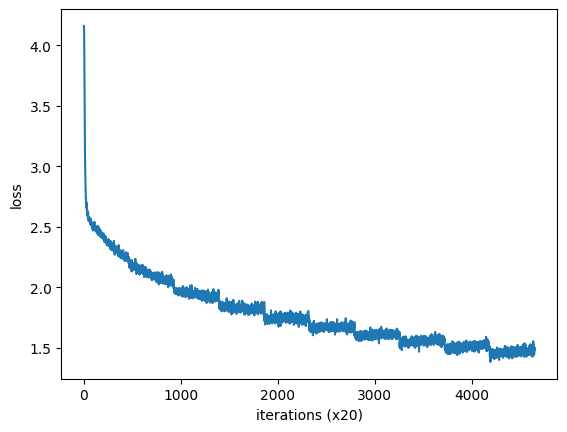

In [1]:
# coding: utf-8
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
from common import config

# GPUで実行する場合は、下記のコメントアウトを消去（要cupy）
# ===============================================
config.GPU = True
# ===============================================
from common.np import *
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from ch04.cbow import CBOW
from ch04.skip_gram import SkipGram
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb


# ハイパーパラメータの設定
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data("train")
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# モデルなどの生成
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 学習開始
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 後ほど利用できるように、必要なデータを保存
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params["word_vecs"] = word_vecs.astype(np.float16)
params["word_to_id"] = word_to_id
params["id_to_word"] = id_to_word
pkl_file = r"C:\Users\jiwon\OneDrive\Desktop\DL2\MyParams\myCBOW_prams.pkl"  # or 'skipgram_params.pkl'
with open(pkl_file, "wb") as f:
    pickle.dump(params, f, -1)


In [ ]:
# coding: utf-8
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
from common.util import most_similar, analogy
import pickle
from common import config
config.GPU = False

pkl_file = r'C:\Users\jiwon\OneDrive\Desktop\DL2\cbow_params.pkl'
# pkl_file = 'skipgram_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# most similar task
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

# analogy task
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


In [1]:
# coding: utf-8
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
from common import config

# GPUで実行する場合は、下記のコメントアウトを消去（要cupy）
# ===============================================
config.GPU = True
# ===============================================
from common.np import *
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from ch04.cbow import CBOW
from ch04.skip_gram import SkipGram
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb


# ハイパーパラメータの設定
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data("train")
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# モデルなどの生成
# model = CBOW(vocab_size, hidden_size, window_size, corpus)
model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 学習開始
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 後ほど利用できるように、必要なデータを保存
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params["word_vecs"] = word_vecs.astype(np.float16)
params["word_to_id"] = word_to_id
params["id_to_word"] = id_to_word
# pkl_file = "cbow_params.pkl"  or
pkl_file = r"C:\Users\jiwon\OneDrive\Desktop\DL2\MyParams\mySkipGram_prams.pkl"
with open(pkl_file, "wb") as f:
    pickle.dump(params, f, -1)


------------------------------------------------------------
                       GPU Mode (cupy)
------------------------------------------------------------

| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 41.59
| epoch 1 |  iter 21 / 9295 | time 2[s] | loss 41.58
| epoch 1 |  iter 41 / 9295 | time 4[s] | loss 41.48
| epoch 1 |  iter 61 / 9295 | time 6[s] | loss 41.05
| epoch 1 |  iter 81 / 9295 | time 8[s] | loss 40.07
| epoch 1 |  iter 101 / 9295 | time 9[s] | loss 38.71
| epoch 1 |  iter 121 / 9295 | time 11[s] | loss 36.89
| epoch 1 |  iter 141 / 9295 | time 13[s] | loss 35.51
| epoch 1 |  iter 161 / 9295 | time 15[s] | loss 34.68
| epoch 1 |  iter 181 / 9295 | time 17[s] | loss 33.89
| epoch 1 |  iter 201 / 9295 | time 19[s] | loss 32.96
| epoch 1 |  iter 221 / 9295 | time 21[s] | loss 32.27
| epoch 1 |  iter 241 / 9295 | time 22[s] | loss 31.96
| epoch 1 |  iter 261 / 9295 | time 24[s] | loss 31.43
| epoch 1 |  iter 281 / 9295 | time 26[s] | loss 31.21
| epoch 1 |  iter 301 / 9

KeyboardInterrupt: 

In [ ]:
# coding: utf-8
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
from common.util import most_similar, analogy
import pickle
from common import config
config.GPU = False

# pkl_file = r'C:\Users\jiwon\OneDrive\Desktop\DL2\cbow_params.pkl'
pkl_file = 'skipgram_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# most similar task
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

# analogy task
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)
